In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

pd.set_option("display.max_columns", None)
plt.rcParams["font.family"] = "IPAexGothic"

import my_modules, model_tuner, features # 自作モジュール

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

c:\Users\ken20\Documents\workspaces\HORSE_RACING\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_pred = pd.read_csv("df_pred.csv")
df_pred.head()

,year,month,day,horse,pred_class_1,pred_class_2,pred_class_3,target,race_id,waku_num
0,2025,2,2,ラファールドール,0.033841,0.039362,0.041342,0,202502020501020205,4
1,2025,2,2,ロードインフェルノ,0.044336,0.060592,0.082243,0,202502020501020204,3
2,2025,2,2,タイセイアーサー,0.023447,0.035971,0.049787,0,202502020501020207,5
3,2025,2,2,ブリスキー,0.096036,0.068693,0.058486,0,202502020501020202,2
4,2025,2,2,マルチライセンス,0.018028,0.025876,0.034216,0,202502020501020203,3


In [3]:
df_pred["id_for_fold"] = df_pred["race_id"] // 100

In [4]:
odds_df = pd.read_csv("wakuren_pred.csv")
odds_df.head(3)

,waku_pair,pred,wakuren_confirmed_odds,id_for_fold,target
0,枠1-1,0.007419,0.0,2025020205010202,0
1,枠1-2,0.014231,21.6,2025020205010202,0
2,枠1-3,0.012786,46.3,2025020205010202,0


ROI: 2.164 %


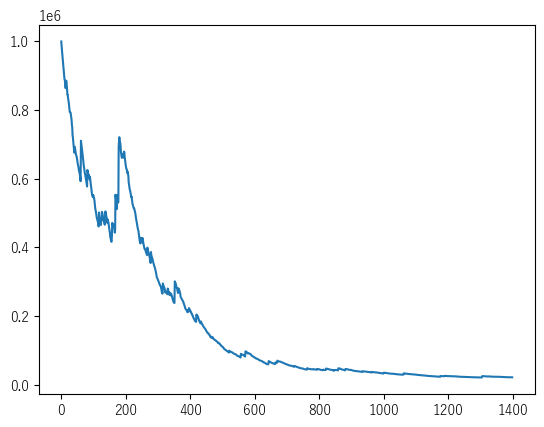

In [8]:
def kelly_calculation(df, prefix=None, kelly_frac=0.5, funds=1_000_000):
    if prefix is None:
        raise ValueError("prefix must be specified")
    df = df.copy()
    # オッズ範囲を1に固定（0の場合を排除）
    df[f"{prefix}_confirmed_odds"] = np.clip(df[f"{prefix}_confirmed_odds"].values, 1, None)
    df["pred"] = np.clip(df["pred"].values, 0, 1)

    b = df[f"{prefix}_confirmed_odds"] - 1
    p = df["pred"]
    q = 1 - p
    f = (b*p - q) / b
    df["kelly_criterion"] = f * kelly_frac
    df["kelly_criterion"] = np.clip(df["kelly_criterion"].values, 0, None)
    
    funds_list = [funds]
    for id, group in df.groupby("id_for_fold", observed=True):
        # 掛け金の計算（100円未満は切り捨て）
        scale = max(1, group["kelly_criterion"].sum())
        group["kelly_criterion"] /= scale
        group["bet_amount"] = funds * group["kelly_criterion"] // 100 * 100
        group["win_amount"] = group["bet_amount"] * group["target"] * group[f"{prefix}_confirmed_odds"]

        sum_bet_amount = group["bet_amount"].sum()
        sum_win_amount = group["win_amount"].sum()

        funds += sum_win_amount - sum_bet_amount
        funds_list.append(funds)

    print(f"ROI: {funds_list[-1] / funds_list[0] * 100} %")

    plt.plot(funds_list)

    return df, funds_list
    

df_calced, funds_list = kelly_calculation(odds_df, prefix="wakuren", kelly_frac=0.1)

In [9]:
from sklearn.metrics import log_loss
df_pred["pred_class_0"] = 1 - df_pred[["pred_class_1", "pred_class_2", "pred_class_3"]].sum(axis=1)
log_loss(df_pred["target"], df_pred[["pred_class_0", "pred_class_1", "pred_class_2", "pred_class_3"]], labels=[0, 1, 2, 3])

0.6364697883116768

In [10]:
df_pred["target"]

0        0
1        0
2        0
3        0
4        0
        ..
19793    0
19794    0
19795    0
19796    0
19797    1
Name: target, Length: 19798, dtype: int64